In [1]:
from mlflux.gotm import read
import pandas as pd
from tqdm import tqdm
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from mlflux.utils import save_ds_compressed

%load_ext autoreload
%autoreload 3

In [2]:
import os

def read_monthly (filename_, year, n1, n2, DELETE=False):
    ''' Auguments:
        filename: file name with placeholder for year and month
        n1: number of data points in time
        n2: number of depth points
    '''
    # days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    ds_months = []

    for i,month in enumerate(range(1,13)):
        filename = filename_ %(year,month)
        print(filename)
        start_date = pd.Timestamp(year=year, month=month, day=1)
        ds = read(filename, n1, n2, start_date)
        ds = ds.where(ds.t.dt.month==month, drop=True)
        ds_months.append(ds)
        if DELETE:
            os.remove(filename)
    
    ds_full = xr.concat(ds_months, dim="t")
    return ds_full

In [3]:
####### Deterministic cases ##########
folder = '/scratch/jw8736/gotm/test/'

MINUTE = 10
method = 'kpp'
f_start = 'out_test_'
f_end = 'dt%g' % MINUTE
year = 2012

n2 = 200 # number of vertical points
n1 = 31 # run for 31 days regardless of months
n1_ = int(n1*24*60/MINUTE) + 1 # depends on output frequency


filename = folder + f_start + f'{method}_%g_%g_' + f_end
ds = read_monthly (filename, year, n1_, n2, DELETE=False)
netcdf_name = folder + f'{method}_%g_dt%g.nc' %(year, MINUTE)
save_ds_compressed(ds, netcdf_name)       

/scratch/jw8736/gotm/test/out_test_kpp_2012_1_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_2_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_3_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_4_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_5_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_6_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_7_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_8_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_9_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_10_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_11_dt10
/scratch/jw8736/gotm/test/out_test_kpp_2012_12_dt10


### Mixed Layer Depth

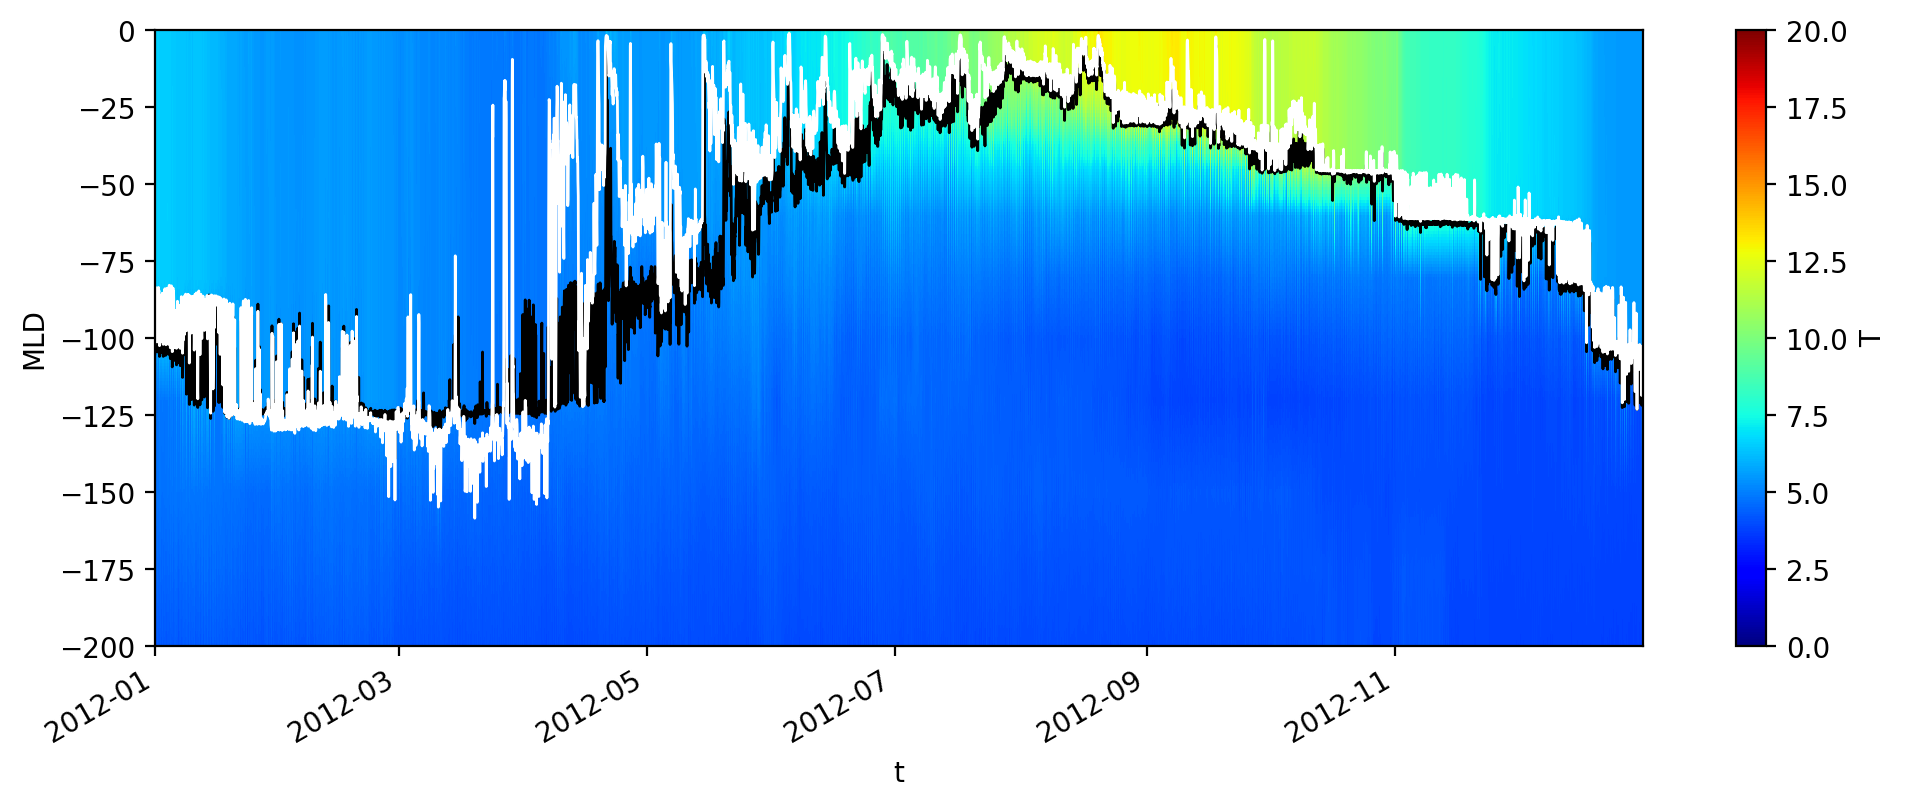

In [27]:
''' Check that MLD looks ok, and temperature and density criteria agree '''

from mlflux.gotm import compute_MLD

folder = '/scratch/jw8736/gotm/shared/'
ds = xr.open_dataset(folder + 'profs.nc')

fig = plt.figure(figsize=[12,4], dpi=200)
vmin=0; vmax=20 

ds.T.sel(t=slice('2012-01-01','2012-12-31')).plot(x='t', cmap='jet', vmin=vmin, vmax=vmax)
ds = compute_MLD(ds,'density')
ds.MLD.sel(t=slice('2012-01-01','2012-12-31')).plot(c='k', lw=1, label='density')
ds = compute_MLD(ds,'temperature')
ds.MLD.sel(t=slice('2012-01-01','2012-12-31')).plot(c='w', lw=1, label='temperature')

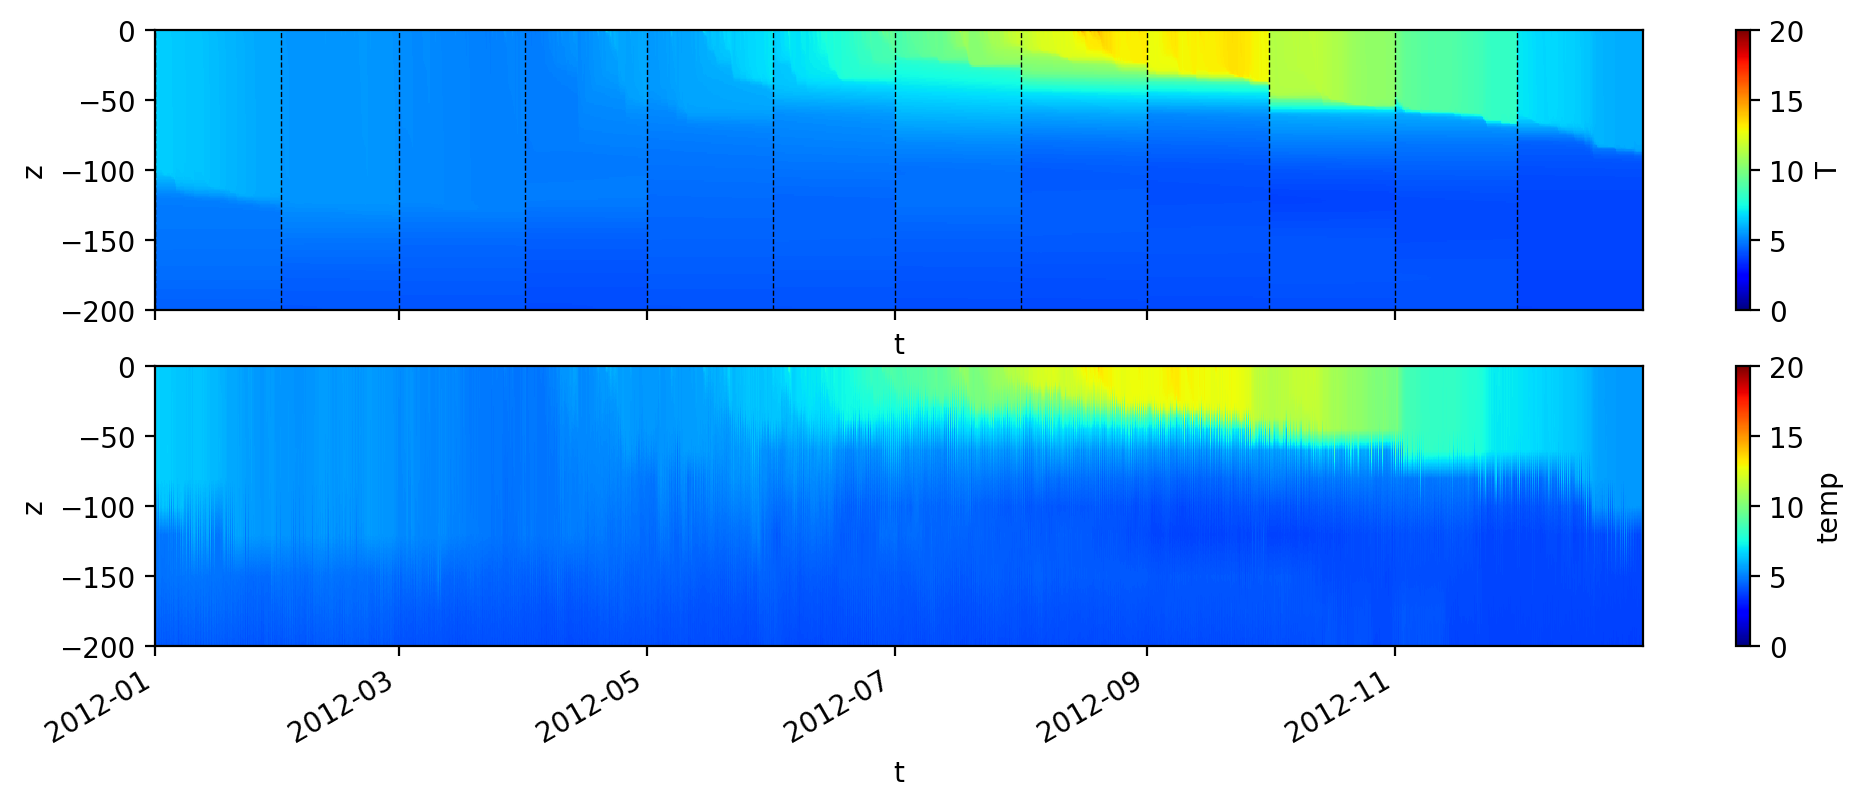

In [45]:
fig, axes = plt.subplots(2, 1, figsize=[12,4], dpi=200, sharex=True)
method = 'kepsilon'
MINUTE = 10
ds = xr.open_dataset(folder+f'{method}_{year}_dt%g.nc' %MINUTE)

vmin=0; vmax=20
ds.T.plot(x='t', cmap='jet', vmin=vmin, vmax=vmax, ax=axes[0])
for i in range(1,13):
    axes[0].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')

folder = '/scratch/jw8736/gotm/shared/'
ds = xr.open_dataset(folder + 'tprof.nc')
ds.temp.sel(t=slice('2012-01-01','2012-12-31')).plot(ax=axes[1], x='t', cmap='jet', vmin=vmin, vmax=vmax)


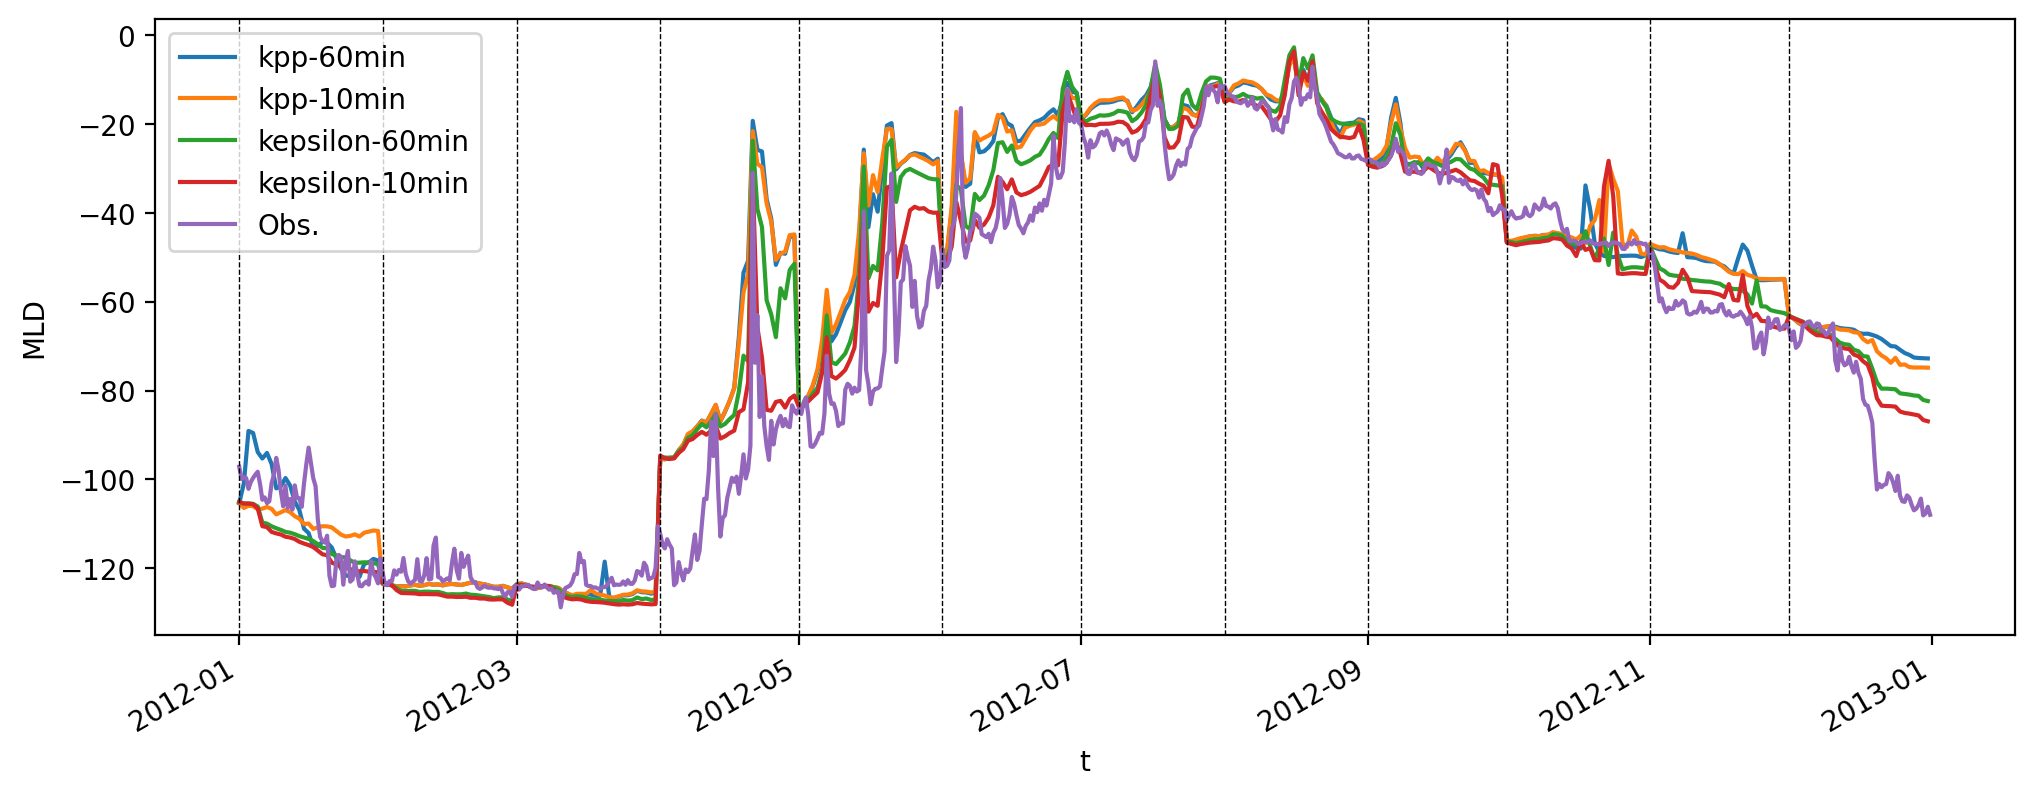

In [47]:
''' MLD smoothed to 12 hours. '''

fig = plt.figure(figsize=[12,4], dpi=200)

year = 2012
folder = '/scratch/jw8736/gotm/test/'
for method in ('kpp', 'kepsilon'):
    for MINUTE in (60,10):
        ds = xr.open_dataset(folder + f'{method}_{year}_dt%g.nc' %MINUTE)
        ds = compute_MLD(ds, 'density')        
        ds.MLD.resample(t='D').mean().plot(label=f'{method}-{MINUTE}min')

folder = '/scratch/jw8736/gotm/shared/'
ds = xr.open_dataset(folder + 'profs.nc')
ds = compute_MLD(ds,'density')
ds.MLD.resample(t='12H').mean().sel(t=slice('2012-01-01','2012-12-31')).plot(label='Obs.')

for i in range(1,13):
    plt.axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')

plt.legend()

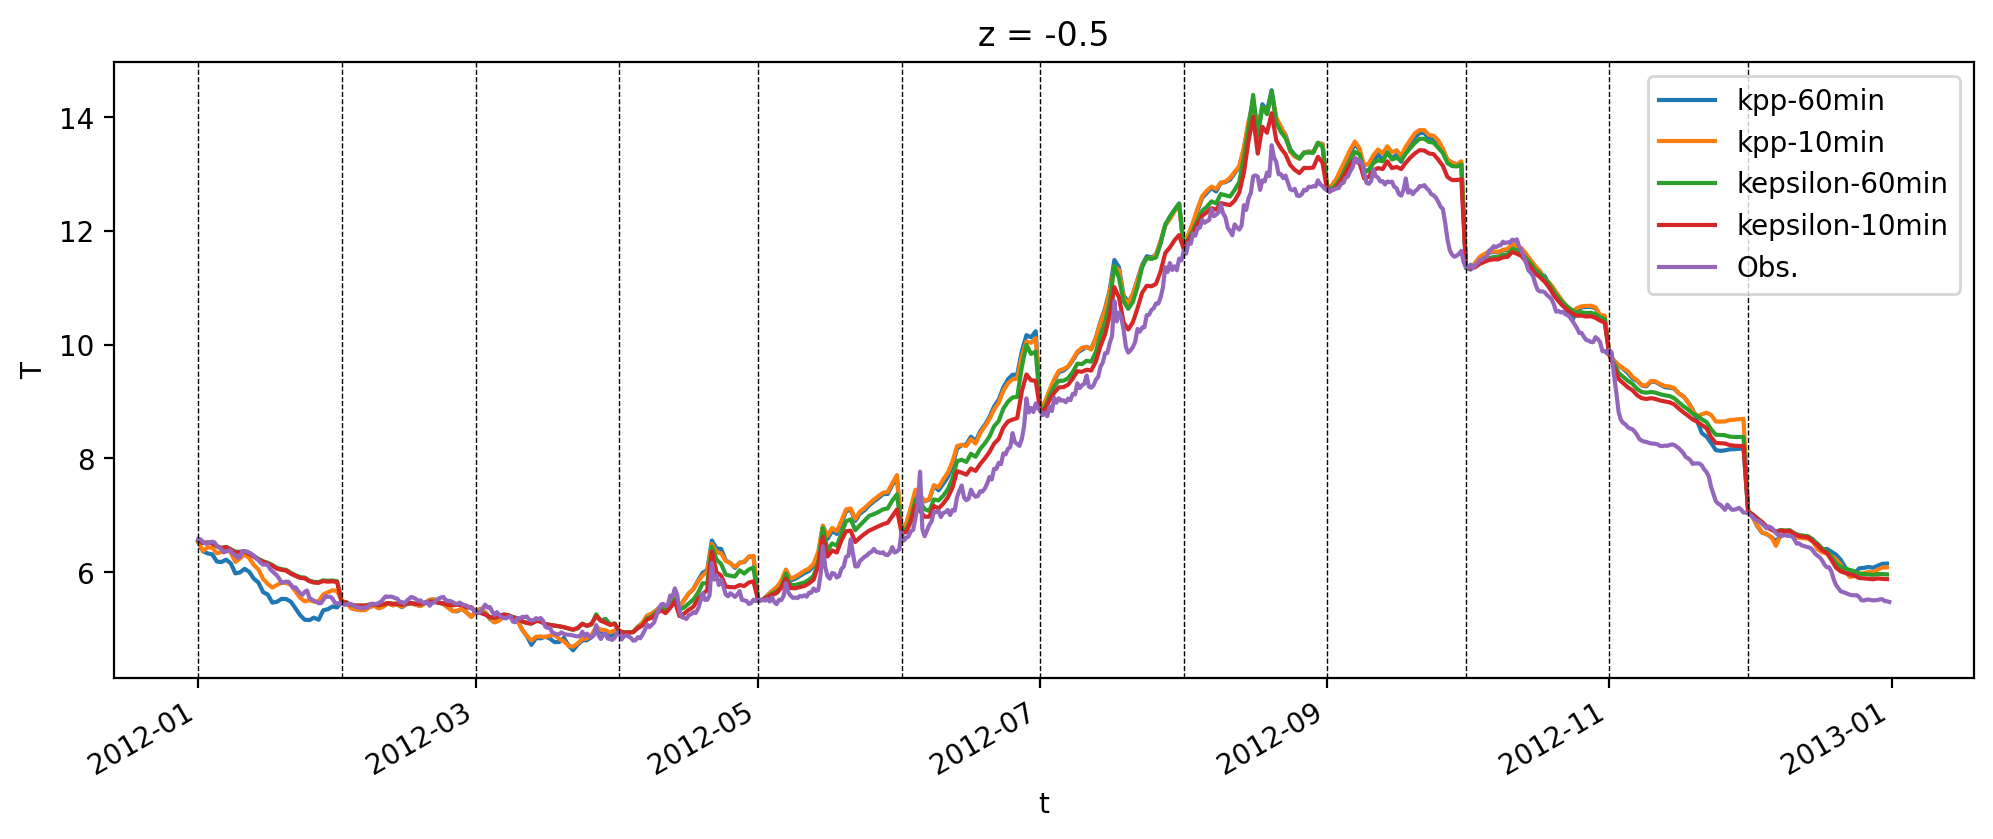

In [46]:
''' SST smoothed to 12 hours. '''

fig = plt.figure(figsize=[12,4], dpi=200)

year = 2012
folder = '/scratch/jw8736/gotm/test/'
for method in ('kpp', 'kepsilon'):
    for MINUTE in (60,10):
        ds = xr.open_dataset(folder + f'{method}_{year}_dt%g.nc' %MINUTE)    
        ds.T.isel(z=-1).resample(t='D').mean().plot(label=f'{method}-{MINUTE}min')

folder = '/scratch/jw8736/gotm/shared/'
ds = xr.open_dataset(folder + 'profs.nc')
ds.T.isel(z=-1).resample(t='12H').mean().sel(t=slice('2012-01-01','2012-12-31')).plot(label='Obs.')

for i in range(1,13):
    plt.axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')

plt.legend()

### Time series of fluxes

In [ ]:
''' Observations for reference. '''
path = '/scratch/jw8736/gotm/shared/'

from mlflux.gotm import read_vars
file_swr = {'filename':'swr.dat', 'columns':['swr']}
file_Q = {'filename':'heatflux.dat', 'columns':['Q']}
files = [file_Q]
df = read_vars (path, files, datetimeformat='%Y-%m-%d %H:%M:%S')

df = df.set_index('datetime')
ds_obs = xr.Dataset.from_dataframe(df)

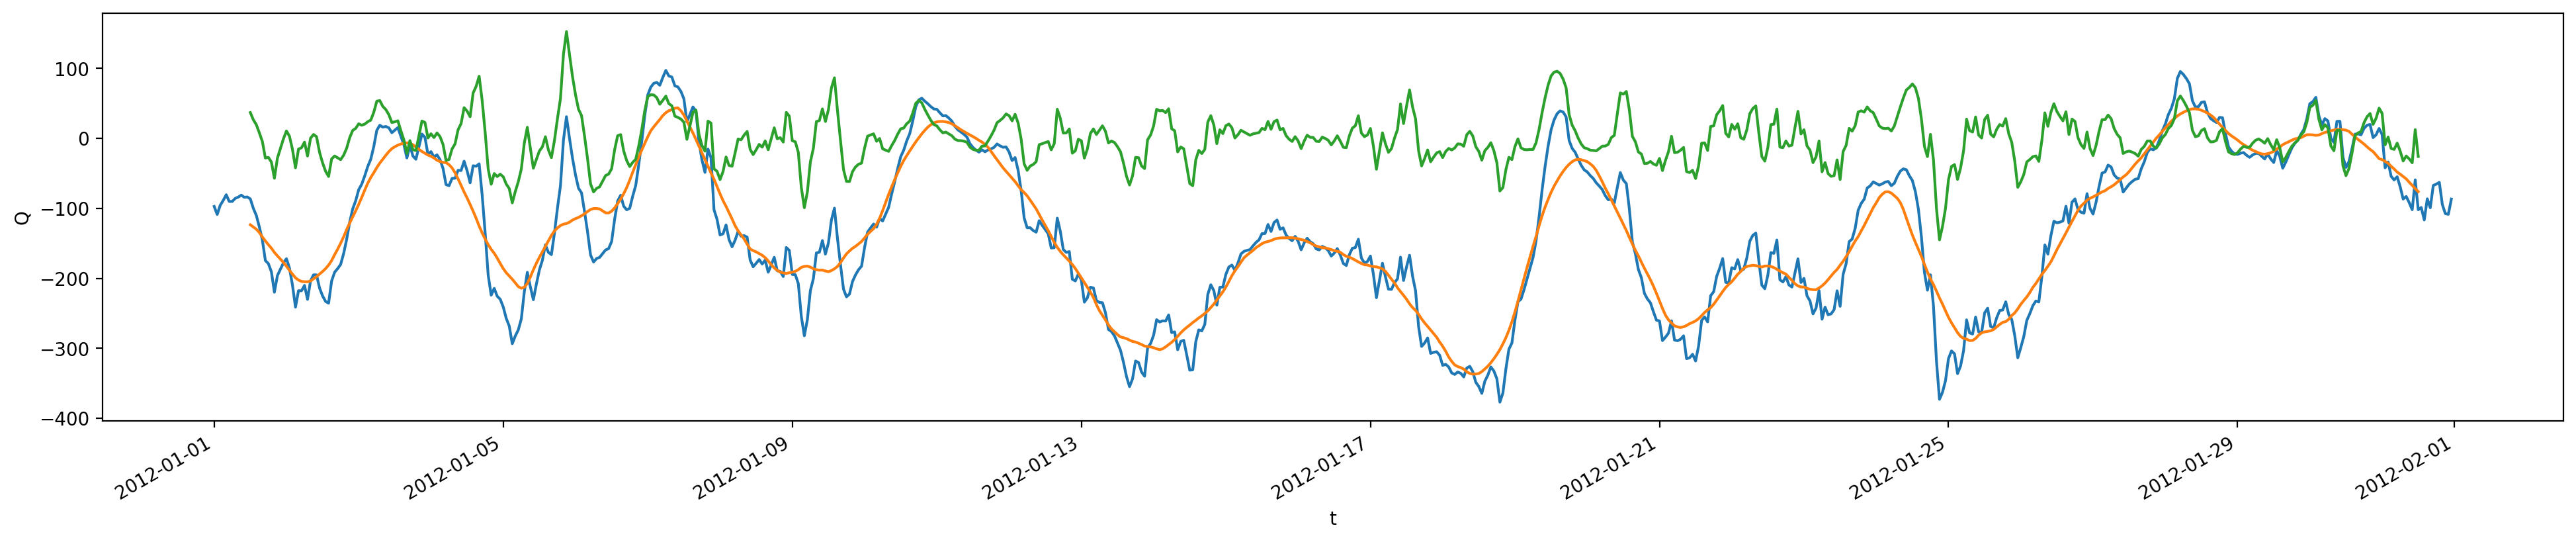

In [77]:
fig = plt.figure(figsize=[24,4], dpi=200)
folder = '/scratch/jw8736/gotm/test/'
method = 'kpp'
year = 2012
MINUTE =60
ds = xr.open_dataset(folder + f'{method}_{year}_dt%g.nc' %MINUTE)   
flux = ds.Q.sel(t=slice('2012-01-01','2012-01-31'))
flux.plot()
filtered_flux = flux.rolling(t=24, center=True).mean()
filtered_flux.plot()
(flux-filtered_flux).plot()

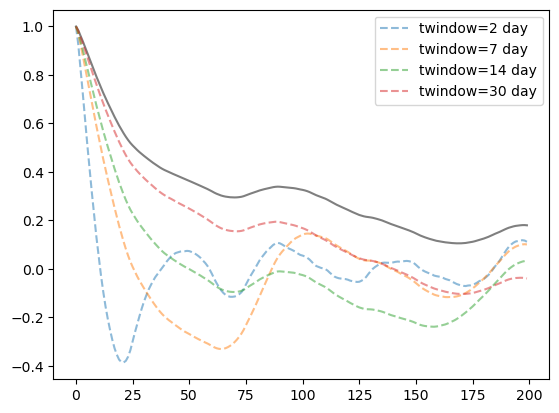

In [114]:
# compute correlation
def compute_corr (ds, FILTER=True, twindow=48):
    if FILTER:
        signal_interp = ds.Q.values - ds.Q.rolling(t=twindow, center=True).mean().fillna(0).values
    else:
        signal_interp = ds.Q.values       
    signal_interp = signal_interp - np.mean(signal_interp) # normalize the series
    correlation = np.correlate(signal_interp, signal_interp, mode='same')/np.sum(signal_interp**2)
    corr = correlation[int(len(correlation)/2):(int(len(correlation)/2)+200)]
    return corr

plt.plot(compute_corr(ds,FILTER=False), c='k', alpha=0.5)
for i in np.array([2,7,14,30]):
    plt.plot(compute_corr(ds, FILTER=True, twindow=24*i), '--', alpha=0.5, label=f'twindow={i} day')

plt.legend()

# fit a correlation time
# k = np.argmin(abs(corr-np.exp(-1)))
# plt.axvline(x=k, color='k', ls='--')
# T = 1/(1 - np.exp(-1/k)) # phi = exp(-1/k) = 1 - Delta_t/T
# print('e-folding time steps: %g, correlation time T: %g hrs' %(k,T))
# # a different way to fit correlation time
# T = 1/(1 - corr[1])
# print('correlation time from lag-1 T: %g hrs' %(T))